# Dataset
> Kaggle link
https://www.kaggle.com/datasets/aayushchou/hospital-length-of-stay-dataset-microsoft

> Source of Dataset
https://microsoft.github.io/r-server-hospital-length-of-stay/index.html

> csv description
https://microsoft.github.io/r-server-hospital-length-of-stay/input_data.html

# Import Libraries and Dataset

In [1]:
# IMPORT NECESSARY LIBRARIES
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import f_regression
from itertools import combinations

Mounted at /content/drive


In [2]:
# IMPORT EXCEL DATA INTO DATAFRAME
file_path = '/content/drive/My Drive/ECGR4105 Final Project/LengthOfStay.csv'
df = pd.read_csv(file_path)
#print(df.head())
#print(df.tail())

# CHECK CONTENTS OF DATASET
#print(df.head)

# QUICK ANALYSIS

### Features
#### Categorical
- End Stage Renal Failure (Receiving Dialysis)\
dialysisrenalendstage
- Asthma\
asthma
- Iron Deficiency\
irondef
- Pneumonia\
pneum
- Substance Use Disorder\
substancedependence
- Major Psychological Disorder\
psychologicaldisordermajor
- Depression\
depress
- Other Psychological Disorder\
psychother
- Fibrosis\
fibrosisandother
- Malnutrition\
malnutrition
- Blood disorder\
hemo

#### Continuous
- Readmission Count (From the last 30 days)\
rcount
- Hematocrit (g/dL)\
hematocrit
- Neutrophil Presence (cells/μL)\
neutrophils
- Sodium Levels (mmol\L)\
sodium
- Blood Glucose Levels (mg/dL)\
glucose
- Blood Urea Nitrogen Levels (mg/dL)\
bloodureanitro
- Creatinine Levels (mg/dL)\
creatinine
- BMI (kg/m²)\
bmi
- Pulse (beats/min)\
pulse
- Respiration Rate (breaths/min)\
respiration

### Target Variables
lengthofstay (LoS): Calculated as Discharge Date - Admission Date\
per American Health Care Association (AHCA)\
https://www.ahcancal.org/Data-and-Research/LTC-Trend-Tracker/Documents/Length%20of%20Stay%20Calculation.pdf

# PREPROCESSING
No bias column needs to be added. sklearn does that automatically when it is used to train model.

## Fix Date Format in .csv file
mm/dd/yyyy --> yyyy-mm-dd\
Required due to initial format having uneven number of digits for month
- EX: Shows 8/01/2000 instead of 08/01/2000

In [3]:
# UPDATE FORMAT
df['vdate'] = pd.to_datetime(df['vdate']).dt.strftime('%Y-%m-%d')
df['discharged'] = pd.to_datetime(df['discharged']).dt.strftime('%Y-%m-%d')

# SAVE TO CORRECT FILED
df.to_csv(file_path, index=False)

## Create Length of Stay (LoS) Column
Column title: lengthofstay

In [4]:
# FUNCTION TO ASSIGN TRUE OR FALSE IF IT IS A LEAP YEAR
def Is_Leap_Year(year):
  if (year % 4 == 0):
    if (year % 100 != 0 or year % 400 == 0):
      return True
    else:
      return False
  else:
    return False

# FUNCTION TO CONVERT DATE INTO A NUMBER OUT OF 365
def Convert_Date_To_Number(month, day, leapYear):
  match(month):
    case 1: # +0
      numDays = day
    case 2: # +31
      numDays = 31 + day
    case 3: # +28
      numDays = 59 + day
    case 4: # +31
      numDays = 90 + day
    case 5: # +30
      numDays = 120 + day
    case 6: # +31
      numDays = 151 + day
    case 7: # +30
      numDays = 181 + day
    case 8: # +31
      numDays = 212 + day
    case 9: # +31
      numDays = 243 + day
    case 10: # +30
      numDays = 273 + day
    case 11: # +31
      numDays = 304 + day
    case 12: # +30
      numDays = 334 + day
  if(leapYear and month > 2):
    numDays += 1
  return numDays

In [5]:
# FUNCTION TO CREATE A 'Length of Stay' COLUMN TO ADD INTO DATASET
def Create_Length_Of_Stay_Column(df): # df will be the original dataset
  # 1. ISOLATE DESIRED COLUMNS AND CREATE RETURN DATAFRAME
  admissionDate = df['vdate']
  dischargeDate = df['discharged']
  lengthDF = pd.DataFrame(columns=['lengthofstay'])

  # ITERATE THROUGH EACH ROW OF DATASET
  for i in range(len(df)):
    # 2. READ DATES AND CONVERT TO NUMBER
    admissionStr = admissionDate.iloc[i]
    admissionYear = int(admissionStr[0:4])
    admissionMonth = int(admissionStr[5:7])
    admissionDay = int(admissionStr[8:10])

    dischargeStr = dischargeDate.iloc[i]
    dischargeYear = int(dischargeStr[0:4])
    dischargeMonth = int(dischargeStr[5:7])
    dischargeDay = int(dischargeStr[8:10])

    # 3. DETERMINE IF LEAP YEAR
    admLeapYear = Is_Leap_Year(admissionYear)
    disLeapYear = Is_Leap_Year(dischargeYear)

    # 4. CONVERT DATES INTO NUMBERS
    admNumDays = Convert_Date_To_Number(admissionMonth, admissionDay, admLeapYear)
    disNumDays = Convert_Date_To_Number(dischargeMonth, dischargeDay, disLeapYear)

    # 5. ACCOUNT FOR DISCHARGE BEING IN THE YEAR AFTER ADMISSION
    if(dischargeYear > admissionYear):
      if(admLeapYear):
        disNumDays += 366
      else:
        disNumDays += 365

    # 6. CALCULATE LENGTH OF STAY AND ADD TO RETURN DATAFRAME
    lengthOfStay = disNumDays - admNumDays
    lengthDF.loc[i] = lengthOfStay

  return lengthDF

In [6]:
# ADD NEW 'Length of Stay' COLUMN AND REMOVE 'vdate' AND 'discharged'
newColumn = Create_Length_Of_Stay_Column(df)
df.drop(columns=['vdate', 'discharged'], inplace=True)
df['lengthofstay'] = newColumn
print(df.head)

<bound method NDFrame.head of           eid rcount gender  dialysisrenalendstage  asthma  irondef  pneum  \
0           1      0      F                      0       0        0      0   
1           2     5+      F                      0       0        0      0   
2           3      1      F                      0       0        0      0   
3           4      0      F                      0       0        0      0   
4           5      0      F                      0       0        0      1   
...       ...    ...    ...                    ...     ...      ...    ...   
99995   99996      3      M                      0       0        0      0   
99996   99997      0      M                      0       0        0      0   
99997   99998      1      M                      0       0        1      0   
99998   99999      0      M                      0       0        0      0   
99999  100000      0      F                      0       0        0      0   

       substancedependence  psych

## Correct rcount
Current values 0, 1, 2, 3, 4, 5+\
5+ comes in as a string and needs to be adjusted to an int. Will use 5 for now.

In [7]:
# SWAP 5 IN PLACE OF 5+
df['rcount'] = df['rcount'].replace('5+', 5).astype(int)


## Examine Feature Distribution

### Categorical Features

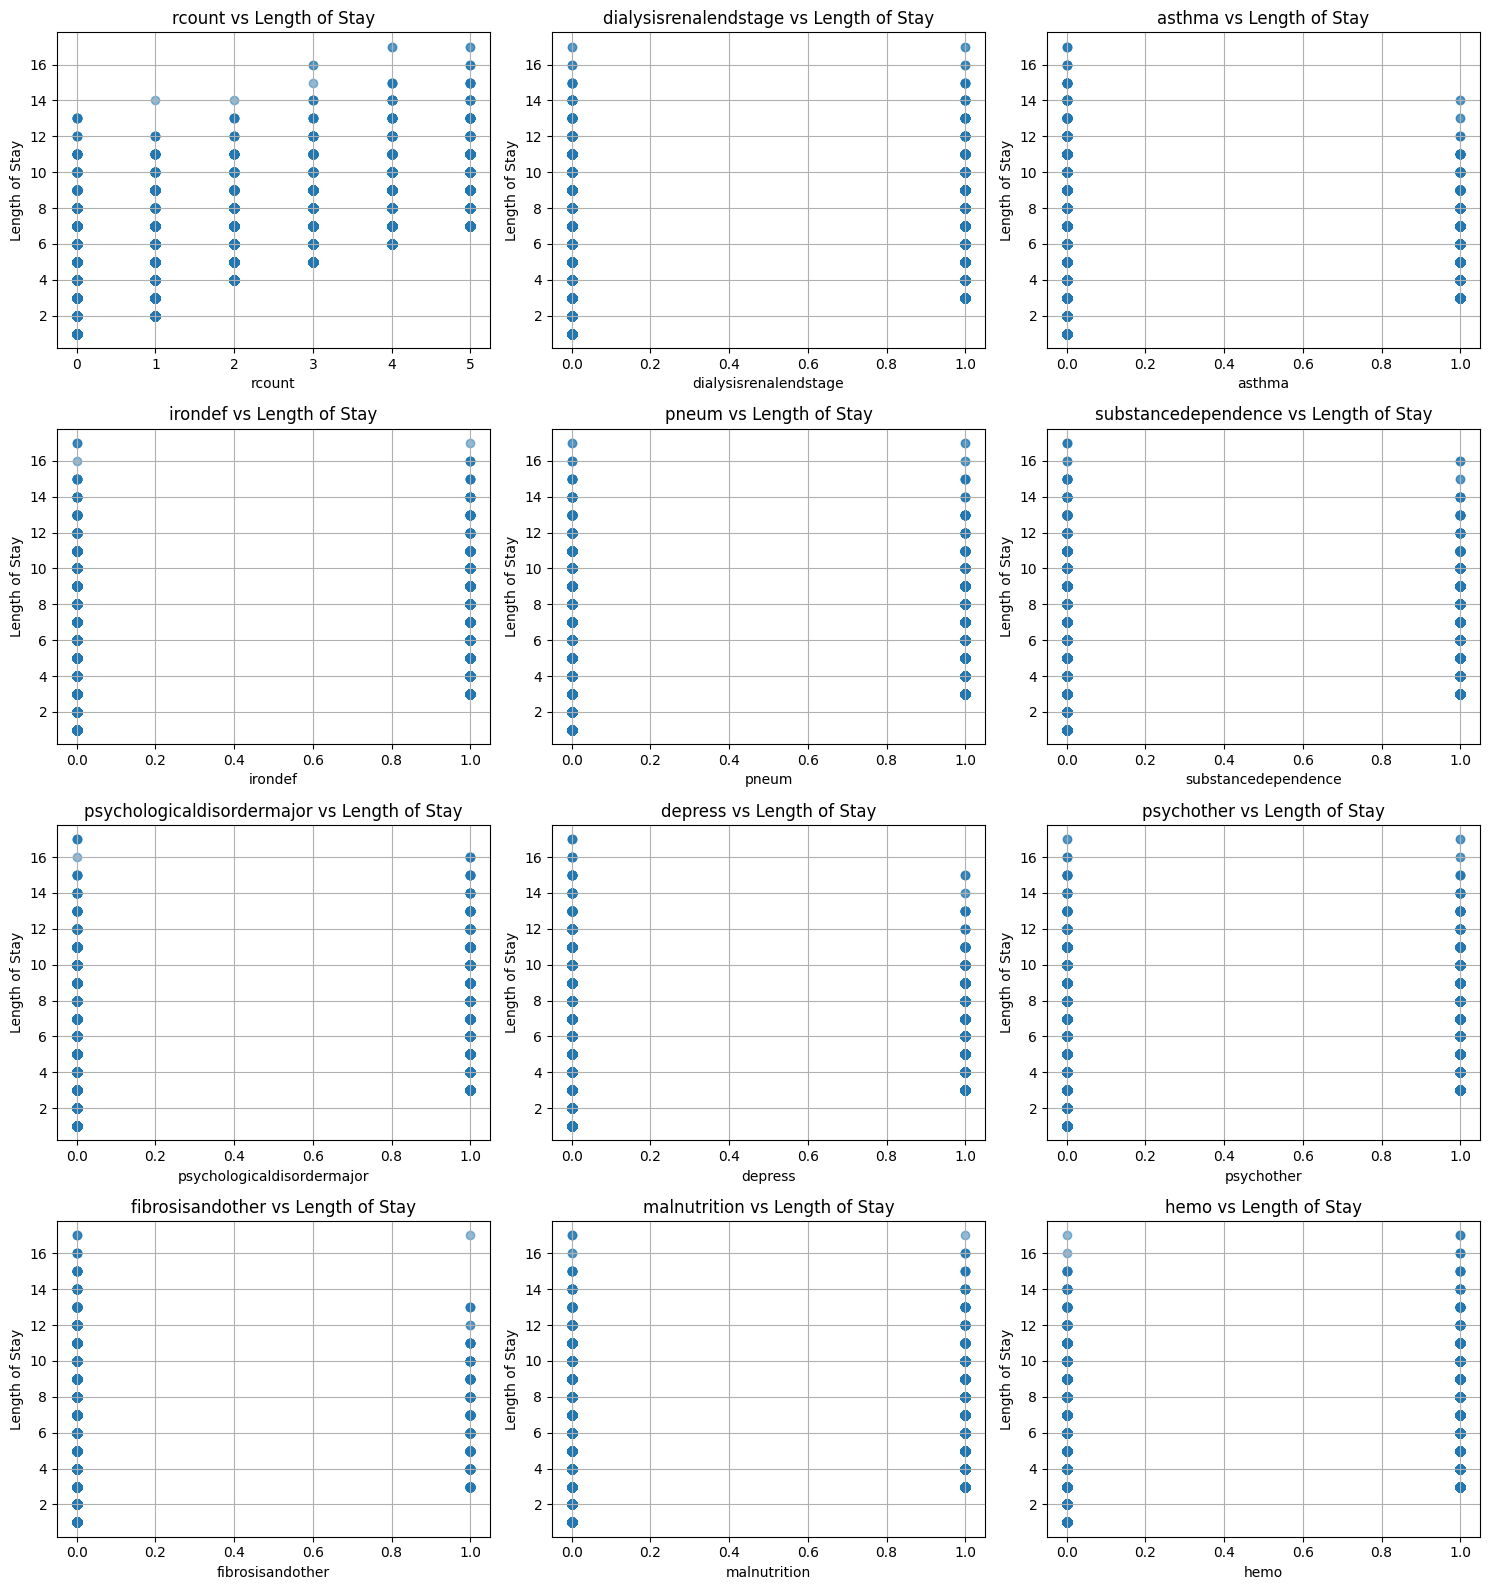

In [8]:
# LIST OF CATEGORICAL VARIABLES TO VISUALIZE
discreteFeatures = ['rcount', 'dialysisrenalendstage', 'asthma', 'irondef', 'pneum', 'substancedependence', 'psychologicaldisordermajor', 'depress', 'psychother', 'fibrosisandother', 'malnutrition', 'hemo']

# Set up subplots
n = len(discreteFeatures)
cols = 3
rows = (n + cols - 1) // cols

plt.figure(figsize=(5 * cols, 4 * rows))

for i, feature in enumerate(discreteFeatures):
    plt.subplot(rows, cols, i + 1)
    plt.scatter(df[feature], df['lengthofstay'], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel("Length of Stay")
    plt.title(f"{feature} vs Length of Stay")
    plt.grid(True)

plt.tight_layout()
plt.show()

### Continuous Features

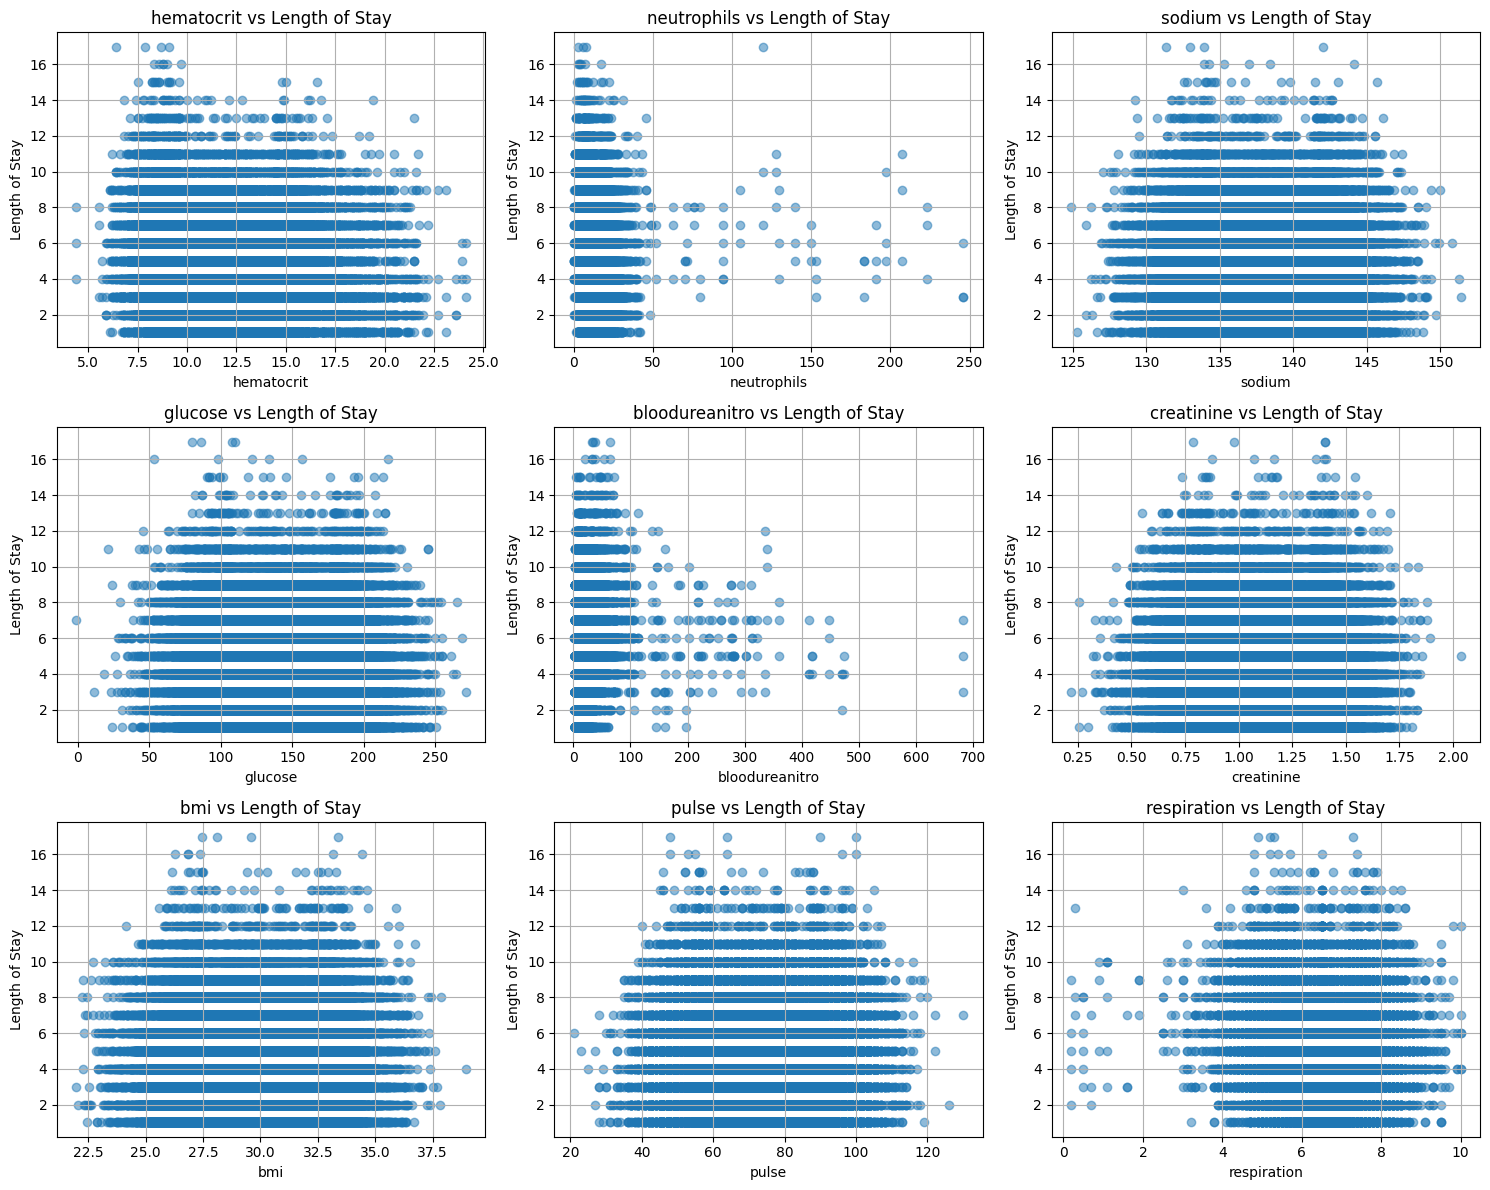

In [9]:
# LIST OF CONTINUOUS VARIABLES TO VISUALIZE
continuousFeatures = ['hematocrit', 'neutrophils', 'sodium', 'glucose', 'bloodureanitro', 'creatinine', 'bmi', 'pulse', 'respiration']

# Set up subplots
n = len(continuousFeatures)
cols = 3
rows = (n + cols - 1) // cols

plt.figure(figsize=(5 * cols, 4 * rows))

for i, feature in enumerate(continuousFeatures):
    plt.subplot(rows, cols, i + 1)
    plt.scatter(df[feature], df['lengthofstay'], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel("Length of Stay")
    plt.title(f"{feature} vs Length of Stay")
    plt.grid(True)

plt.tight_layout()
plt.show()

## Split into Training and Test Data

In [10]:
# SPLIT DATASET INTO FEATURES AND TARGET VARIABLE
X = df.drop(columns=['lengthofstay', 'eid', 'gender', 'secondarydiagnosisnonicd9', 'facid'], axis=1)
y = df['lengthofstay']
#print(X)
#print(y)

# SPLIT DATA INTO TRAINING AND VALIDATION SET
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=25) # I thought of something funnier than 24...

## Normalize and Standardize

In [11]:
# CREATE SCALAR OBJECTS
normScaler = MinMaxScaler()
stdScaler = StandardScaler()

# DEFINE FEATURES TO SCALE (non-binary only)
SCALED_COLS = ['hematocrit', 'neutrophils', 'sodium', 'glucose',
               'bloodureanitro', 'creatinine', 'bmi', 'pulse', 'respiration']

# NORMALIZE DATA
normScaler.fit(trainX[SCALED_COLS])
normTrainX_scaled = normScaler.transform(trainX[SCALED_COLS])
normTestX_scaled = normScaler.transform(testX[SCALED_COLS])

# STANDARDIZE DATA
stdScaler.fit(trainX[SCALED_COLS])
stdTrainX_scaled = stdScaler.transform(trainX[SCALED_COLS])
stdTestX_scaled = stdScaler.transform(testX[SCALED_COLS])

# CONVERT BACK TO DATAFRAMES WITH ORIGINAL INDICES
normTrainX_scaled = pd.DataFrame(normTrainX_scaled, columns=SCALED_COLS, index=trainX.index)
normTestX_scaled = pd.DataFrame(normTestX_scaled, columns=SCALED_COLS, index=testX.index)
stdTrainX_scaled = pd.DataFrame(stdTrainX_scaled, columns=SCALED_COLS, index=trainX.index)
stdTestX_scaled = pd.DataFrame(stdTestX_scaled, columns=SCALED_COLS, index=testX.index)

# COPY ORIGINAL DATASETS
normTrainX_temp = trainX.copy()
normTestX_temp = testX.copy()
stdTrainX_temp = trainX.copy()
stdTestX_temp = testX.copy()

# REPLACE ONLY THE COLUMNS THAT WERE SCALED
for col in SCALED_COLS:
    normTrainX_temp[col] = normTrainX_scaled[col]
    normTestX_temp[col] = normTestX_scaled[col]
    stdTrainX_temp[col] = stdTrainX_scaled[col]
    stdTestX_temp[col] = stdTestX_scaled[col]

# FINAL DATASETS
normTrainX = normTrainX_temp
normTestX = normTestX_temp
stdTrainX = stdTrainX_temp
stdTestX = stdTestX_temp

# VALIDATION
if(False):
  print(normTrainX)
  print('\n\n', normTestX)
  print('\n\n', stdTrainX)
  print('\n\n', stdTestX)



In [12]:
# PREPARE TARGET VARIABLE COLUMN VECTOR
trainY = trainY.to_numpy().reshape(-1,1)
testY = testY.to_numpy().reshape(-1,1)

In [13]:
# CONVERT NORM & STD NUMPY'S BACK INTO DF IF NEEDED LATER
normTrainX_df = pd.DataFrame(normTrainX)
normTestX_df = pd.DataFrame(normTestX)
stdTrainX_df = pd.DataFrame(stdTrainX)
stdTestX_df = pd.DataFrame(stdTestX)

# ASSIGN CORRECT COLUMNS TO EACH DF
normTrainX_df.columns = X.columns
normTestX_df.columns = X.columns
stdTrainX_df.columns = X.columns
stdTestX_df.columns = X.columns

# VALIDATION
print(normTrainX_df.head())

       rcount  dialysisrenalendstage  asthma  irondef  pneum  \
28998       3                      0       0        0      0   
54106       2                      0       0        0      0   
73975       1                      0       0        0      0   
33453       4                      0       0        0      0   
72290       4                      0       0        0      0   

       substancedependence  psychologicaldisordermajor  depress  psychother  \
28998                    0                           0        0           0   
54106                    0                           0        0           0   
73975                    0                           0        0           0   
33453                    0                           0        0           0   
72290                    0                           1        0           0   

       fibrosisandother  ...  hemo  hematocrit  neutrophils    sodium  \
28998                 0  ...     0    0.284264     0.043124  0.3666

## Create Single Feature Arrays for Univariate Training

In [14]:
# CREATE NUMPY ARRAY FOR RCOUNT
rcount_trainX = trainX['rcount'].to_numpy().reshape(-1,1)
rcount_testX = testX['rcount'].to_numpy().reshape(-1,1)

# CREATE NUMPY ARRAY FOR HEMATOCRIT
hematocrit_trainX = trainX['hematocrit'].to_numpy().reshape(-1,1)
hematocrit_testX = testX['hematocrit'].to_numpy().reshape(-1,1)

# CREATE NUMPY ARRAY FOR NEUTROPHILS
neutrophils_trainX = trainX['neutrophils'].to_numpy().reshape(-1,1)
neutrophils_testX = testX['neutrophils'].to_numpy().reshape(-1,1)

# CREATE NUMPY ARRAY FOR SODIUM
sodium_trainX = trainX['sodium'].to_numpy().reshape(-1,1)
sodium_testX = testX['sodium'].to_numpy().reshape(-1,1)

# CREATE NUMPY ARRAY FOR GLUCOSE
glucose_trainX = trainX['glucose'].to_numpy().reshape(-1,1)
glucose_testX = testX['glucose'].to_numpy().reshape(-1,1)

# CREATE NUMPY ARRAY FOR BLOODUREANITRO
bloodureanitro_trainX = trainX['bloodureanitro'].to_numpy().reshape(-1,1)
bloodureanitro_testX = testX['bloodureanitro'].to_numpy().reshape(-1,1)

# CREATE NUMPY ARRAY FOR CREATININE
creatinine_trainX = trainX['creatinine'].to_numpy().reshape(-1,1)
creatinine_testX = testX['creatinine'].to_numpy().reshape(-1,1)

# CREATE NUMPY ARRAY FOR BMI
bmi_trainX = trainX['bmi'].to_numpy().reshape(-1,1)
bmi_testX = testX['bmi'].to_numpy().reshape(-1,1)

# CREATE NUMPY ARRAY FOR PULSE
pulse_trainX = trainX['pulse'].to_numpy().reshape(-1,1)
pulse_testX = testX['pulse'].to_numpy().reshape(-1,1)

# CREATE NUMPY ARRAY FOR RESPIRATION
respiration_trainX = trainX['respiration'].to_numpy().reshape(-1,1)
respiration_testX = testX['respiration'].to_numpy().reshape(-1,1)

# VARIABLES
## Multivariate Model
- normTrainX
- normTestX
- stdTrainX
- stdTestX

## Univariate Models (Not normalized or standardized)
- hematocrit_trainX
- hematocrit_testX
---
- neutrophils_trainX
- neutrophils_testX
---
- sodium_trainX
- sodium_testX
---
- glucose_trainX
- glucose_testX
---
- bloodureanitro_trainX
- bloodureanitro_testX
---
- creatinine_trainX
- creatinine_testX
---
- bmi_trainX
- bmi_testX
---
- pulse_trainX
- pulse_testX
---
- respiration_trainX
- respiration_testX

## Target Variables
- trainY
- testY




# TRAINING MULTIVARIATE MODEL

In [15]:
# CREATE SKLEARN MODEL OBJECTS
skNormModel = LinearRegression()
skStdModel = LinearRegression()

# TRAIN MODELS
skNormModel.fit(normTrainX, trainY)
skStdModel.fit(stdTrainX, trainY)

# MAKE PREDICTIONS
# Normalized Predictions
normTrainPred = skNormModel.predict(normTrainX)
normTestPred = skNormModel.predict(normTestX)
# Standardized Predictions
stdTrainPred = skStdModel.predict(stdTrainX)
stdTestPred = skStdModel.predict(stdTestX)

## Normalized Data

### Performance Plot

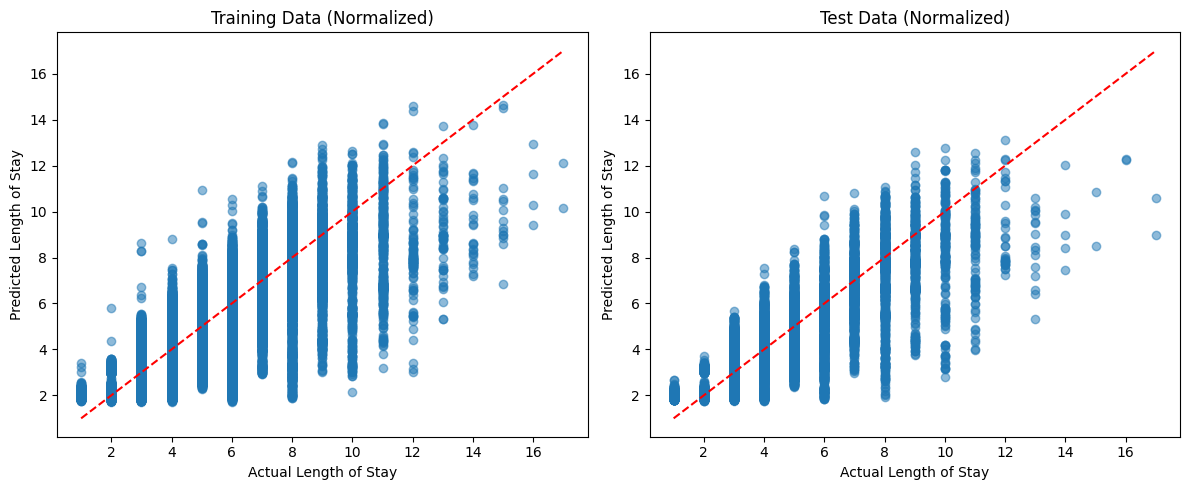

In [16]:
# PLOT
plt.figure(figsize=(12, 5))

# TRAINING DATA
plt.subplot(1, 2, 1)
plt.scatter(trainY, normTrainPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Training Data (Normalized)")
plt.plot([trainY.min(), trainY.max()], [trainY.min(), trainY.max()], 'r--')

# TEST DATA
plt.subplot(1, 2, 2)
plt.scatter(testY, normTestPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Test Data (Normalized)")
plt.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'r--')

plt.tight_layout()
plt.show()

### Metrics

In [17]:
# CHECK METRICS OF SKLEARN NORMALIZED MODEL
print("R² score:", r2_score(testY, normTestPred))
print("MSE:", mean_squared_error(testY, normTestPred))
print("MAE:", mean_absolute_error(testY, normTestPred))

R² score: 0.7497501943219166
MSE: 1.4011725852473875
MAE: 0.8999377179538436


## Standardized Data

### Performance Plot

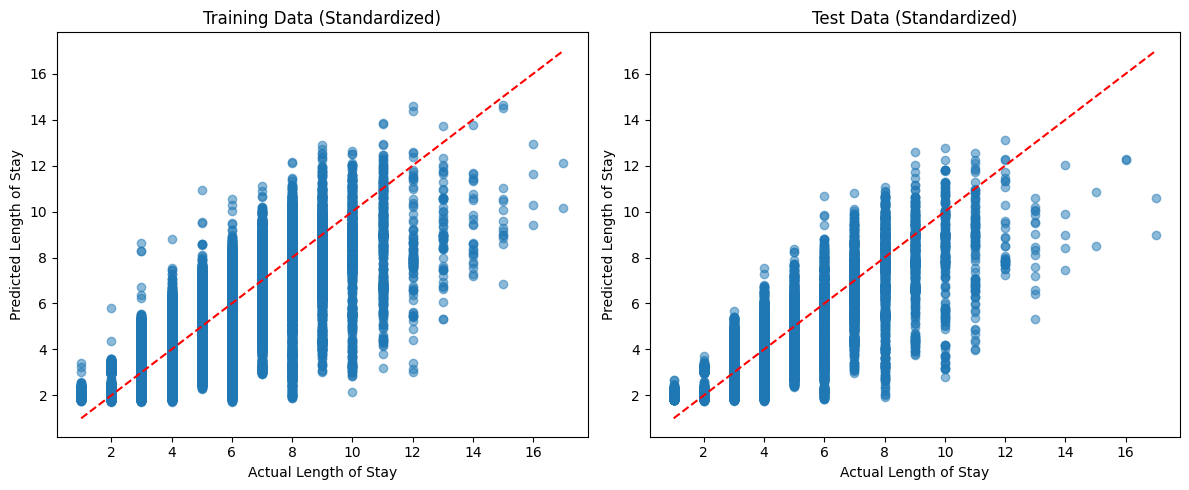

In [18]:
# PLOT
plt.figure(figsize=(12, 5))

# TRAINING DATA
plt.subplot(1, 2, 1)
plt.scatter(trainY, stdTrainPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Training Data (Standardized)")
plt.plot([trainY.min(), trainY.max()], [trainY.min(), trainY.max()], 'r--')

# TEST DATA
plt.subplot(1, 2, 2)
plt.scatter(testY, stdTestPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Test Data (Standardized)")
plt.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'r--')

plt.tight_layout()
plt.show()

### Metrics

In [19]:
# CHECK METRICS OF SKLEARN STANDARDIZED MODEL
print("R² score:", r2_score(testY, stdTestPred))
print("MSE:", mean_squared_error(testY, stdTestPred))
print("MAE:", mean_absolute_error(testY, stdTestPred))

R² score: 0.7497501943219166
MSE: 1.4011725852473875
MAE: 0.8999377179538438


## Feature Weights

### Normalized

In [20]:
# Get feature names and weights
feature_names = normTrainX_df.columns
norm_weights = skNormModel.coef_.flatten()

# Pair them and sort alphabetically
norm_feature_weights = sorted(zip(feature_names, norm_weights), key=lambda x: x[0])

# Display
print("Normalized Model Feature Weights (Alphabetical):\n")
for feature, weight in norm_feature_weights:
    print(f"{feature}: {weight:.4f}")

Normalized Model Feature Weights (Alphabetical):

asthma: 0.8397
bloodureanitro: 5.6095
bmi: 0.0310
creatinine: 0.0101
depress: 0.4919
dialysisrenalendstage: 0.7482
fibrosisandother: 1.1790
glucose: 0.0060
hematocrit: 0.3490
hemo: 1.2615
irondef: 0.7703
malnutrition: 0.5061
neutrophils: 4.4919
pneum: 0.6808
psychologicaldisordermajor: 1.2380
psychother: 0.7699
pulse: -0.0112
rcount: 1.1494
respiration: -0.1783
sodium: -0.0194
substancedependence: 0.9175


### Standardized

In [21]:
std_weights = skStdModel.coef_.flatten()
std_feature_weights = sorted(zip(feature_names, std_weights), key=lambda x: x[0])

print("\nStandardized Model Feature Weights (Alphabetical):\n")
for feature, weight in std_feature_weights:
    print(f"{feature}: {weight:.4f}")


Standardized Model Feature Weights (Alphabetical):

asthma: 0.8397
bloodureanitro: 0.1077
bmi: 0.0037
creatinine: 0.0011
depress: 0.4919
dialysisrenalendstage: 0.7482
fibrosisandother: 1.1790
glucose: 0.0007
hematocrit: 0.0360
hemo: 1.2615
irondef: 0.7703
malnutrition: 0.5061
neutrophils: 0.0989
pneum: 0.6808
psychologicaldisordermajor: 1.2380
psychother: 0.7699
pulse: -0.0012
rcount: 1.1494
respiration: -0.0104
sodium: -0.0022
substancedependence: 0.9175


# TRAINING UNIVARIATE MODELS

## Readmission Count

In [22]:
# CREATE MODEL OBJECT
rcountModel = LinearRegression()

# TRAIN MODEL
rcountModel.fit(rcount_trainX, trainY)

# MAKE PREDICTIONS
rcountTrainPred = rcountModel.predict(rcount_trainX)
rcountTestPred = rcountModel.predict(rcount_testX)

### Performance Plot

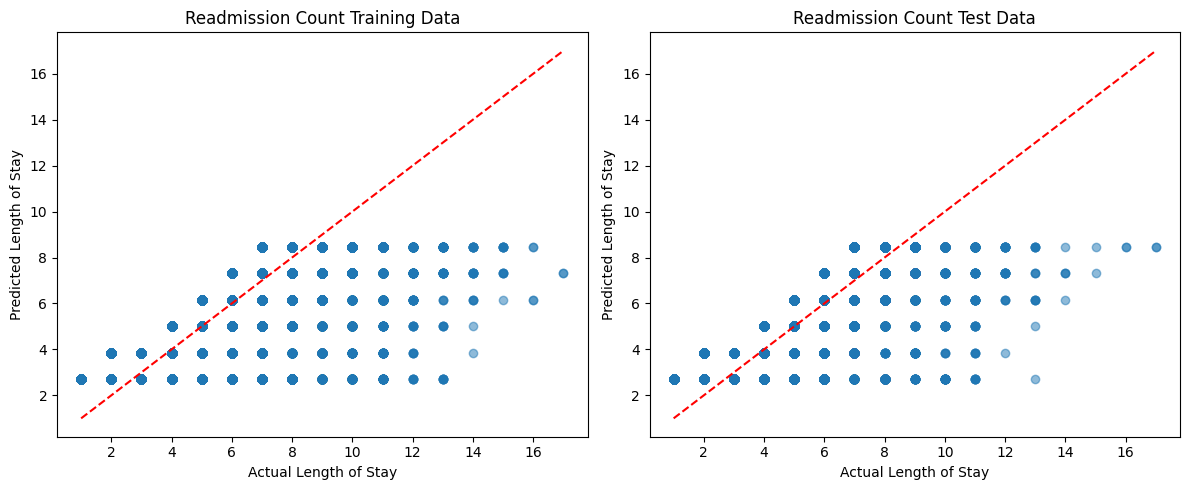

In [23]:
# PLOT
plt.figure(figsize=(12, 5))

# TRAINING DATA
plt.subplot(1, 2, 1)
plt.scatter(trainY, rcountTrainPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Readmission Count Training Data")
plt.plot([trainY.min(), trainY.max()], [trainY.min(), trainY.max()], 'r--')

# TEST DATA
plt.subplot(1, 2, 2)
plt.scatter(testY, rcountTestPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Readmission Count Test Data")
plt.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'r--')

plt.tight_layout()
plt.show()

### Metrics

In [24]:
# CHECK METRICS OF MODEL
print("R² score:", r2_score(testY, rcountTestPred))
print("MSE:", mean_squared_error(testY, rcountTestPred))
print("MAE:", mean_absolute_error(testY, rcountTestPred))

R² score: 0.5621946347878031
MSE: 2.4513140929214914
MAE: 1.2295565498980536


## Hematocrit

In [25]:
# CREATE MODEL OBJECT
hematocritModel = LinearRegression()

# TRAIN MODEL
hematocritModel.fit(hematocrit_trainX, trainY)

# MAKE PREDICTIONS
hematocritTrainPred = hematocritModel.predict(hematocrit_trainX)
hematocritTestPred = hematocritModel.predict(hematocrit_testX)

### Performance Plot

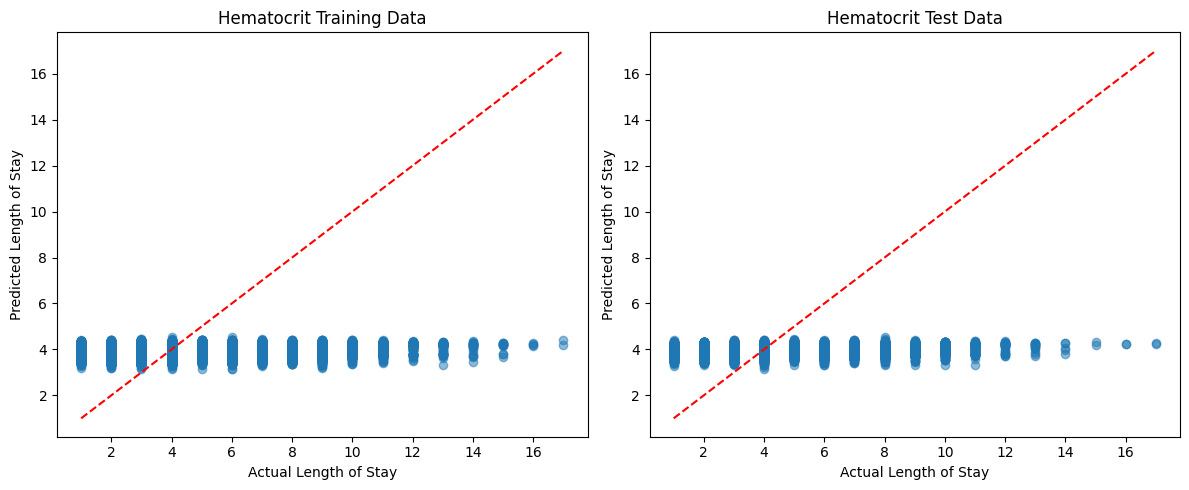

In [26]:
# PLOT
plt.figure(figsize=(12, 5))

# TRAINING DATA
plt.subplot(1, 2, 1)
plt.scatter(trainY, hematocritTrainPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Hematocrit Training Data")
plt.plot([trainY.min(), trainY.max()], [trainY.min(), trainY.max()], 'r--')

# TEST DATA
plt.subplot(1, 2, 2)
plt.scatter(testY, hematocritTestPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Hematocrit Test Data")
plt.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'r--')

plt.tight_layout()
plt.show()

### Metrics

In [27]:
# CHECK METRICS OF MODEL
print("R² score:", r2_score(testY, hematocritTestPred))
print("MSE:", mean_squared_error(testY, hematocritTestPred))
print("MAE:", mean_absolute_error(testY, hematocritTestPred))

R² score: 0.005484014690542716
MSE: 5.568390074989558
MAE: 1.9202376553862033


## Neutrophils

In [28]:
# CREATE MODEL OBJECT
neutrophilsModel = LinearRegression()

# TRAIN MODEL
neutrophilsModel.fit(neutrophils_trainX, trainY)

# MAKE PREDICTIONS
neutrophilsTrainPred = neutrophilsModel.predict(neutrophils_trainX)
neutrophilsTestPred = neutrophilsModel.predict(neutrophils_testX)

### Performance Plot

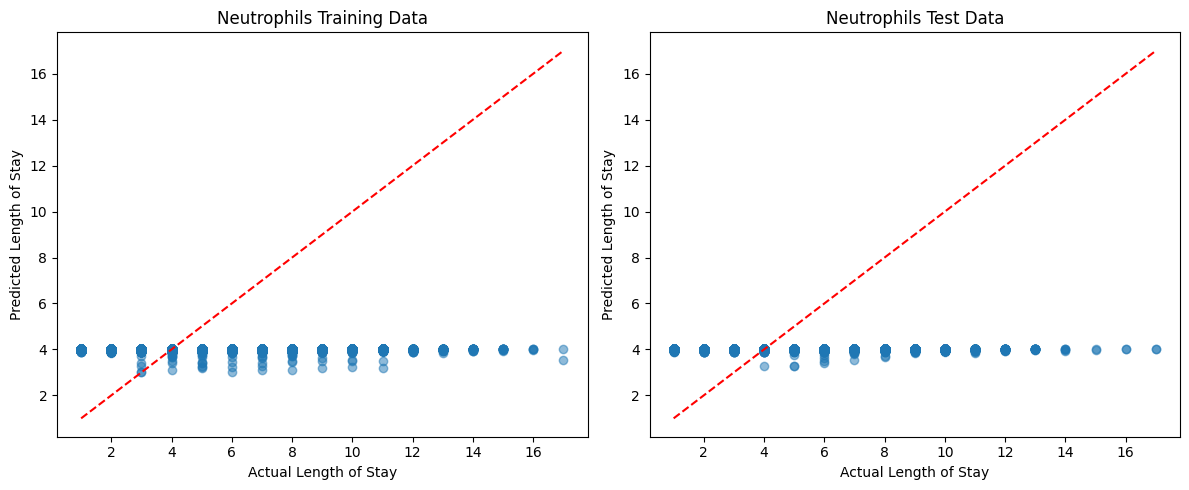

In [29]:
# PLOT
plt.figure(figsize=(12, 5))

# TRAINING DATA
plt.subplot(1, 2, 1)
plt.scatter(trainY, neutrophilsTrainPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Neutrophils Training Data")
plt.plot([trainY.min(), trainY.max()], [trainY.min(), trainY.max()], 'r--')

# TEST DATA
plt.subplot(1, 2, 2)
plt.scatter(testY, neutrophilsTestPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Neutrophils Test Data")
plt.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'r--')

plt.tight_layout()
plt.show()

### Metrics

In [30]:
# CHECK METRICS OF MODEL
print("R² score:", r2_score(testY, neutrophilsTestPred))
print("MSE:", mean_squared_error(testY, neutrophilsTestPred))
print("MAE:", mean_absolute_error(testY, neutrophilsTestPred))

R² score: 0.00014222732034141483
MSE: 5.598299253136832
MAE: 1.9152448248331482


## Sodium

In [31]:
# CREATE MODEL OBJECT
sodiumModel = LinearRegression()

# TRAIN MODEL
sodiumModel.fit(sodium_trainX, trainY)

# MAKE PREDICTIONS
sodiumTrainPred = sodiumModel.predict(sodium_trainX)
sodiumTestPred = sodiumModel.predict(sodium_testX)

### Performance Plot

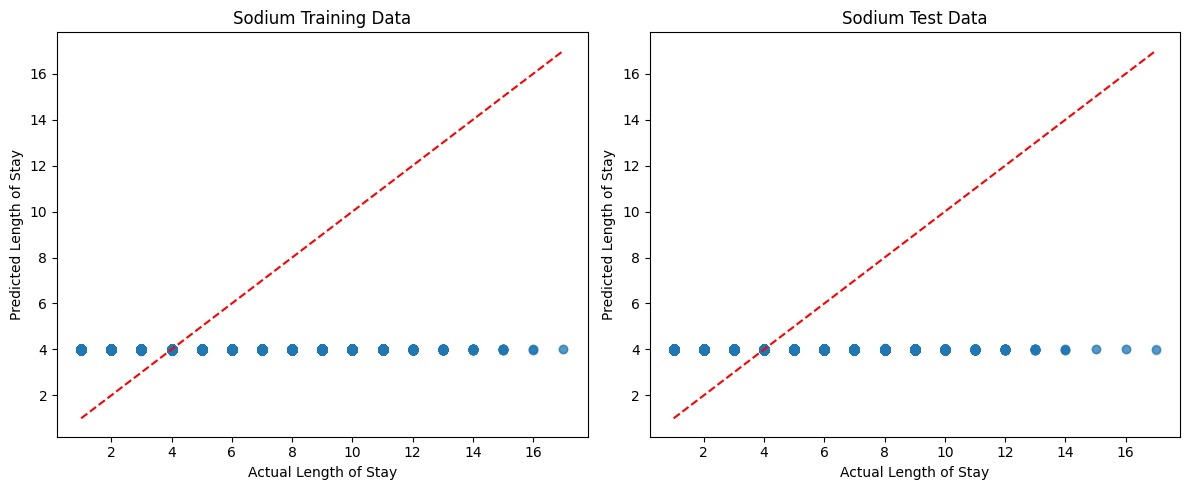

In [32]:
# PLOT
plt.figure(figsize=(12, 5))

# TRAINING DATA
plt.subplot(1, 2, 1)
plt.scatter(trainY, sodiumTrainPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Sodium Training Data")
plt.plot([trainY.min(), trainY.max()], [trainY.min(), trainY.max()], 'r--')

# TEST DATA
plt.subplot(1, 2, 2)
plt.scatter(testY, sodiumTestPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Sodium Test Data")
plt.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'r--')

plt.tight_layout()
plt.show()

### Metrics

In [33]:
# CHECK METRICS OF MODEL
print("R² score:", r2_score(testY, sodiumTestPred))
print("MSE:", mean_squared_error(testY, sodiumTestPred))
print("MAE:", mean_absolute_error(testY, sodiumTestPred))

R² score: -7.388844138089823e-05
MSE: 5.599509305946842
MAE: 1.9150655710554074


## Glucose

In [34]:
# CREATE MODEL OBJECT
glucoseModel = LinearRegression()

# TRAIN MODEL
glucoseModel.fit(glucose_trainX, trainY)

# MAKE PREDICTIONS
glucoseTrainPred = glucoseModel.predict(glucose_trainX)
glucoseTestPred = glucoseModel.predict(glucose_testX)

### Performance Plot

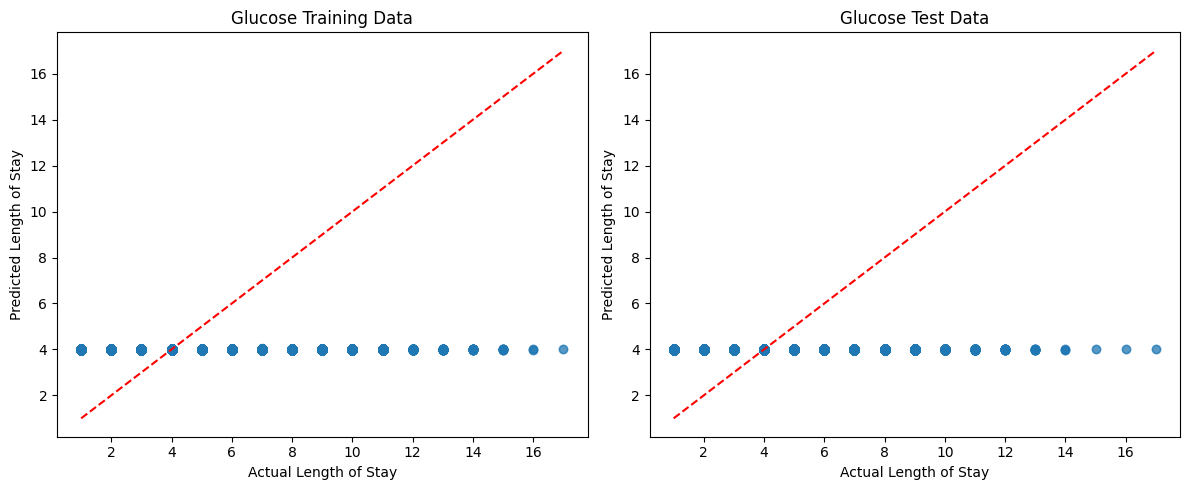

In [35]:
# PLOT
plt.figure(figsize=(12, 5))

# TRAINING DATA
plt.subplot(1, 2, 1)
plt.scatter(trainY, glucoseTrainPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Glucose Training Data")
plt.plot([trainY.min(), trainY.max()], [trainY.min(), trainY.max()], 'r--')

# TEST DATA
plt.subplot(1, 2, 2)
plt.scatter(testY, glucoseTestPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Glucose Test Data")
plt.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'r--')

plt.tight_layout()
plt.show()

### Metrics

In [36]:
# CHECK METRICS OF MODEL
print("R² score:", r2_score(testY, glucoseTestPred))
print("MSE:", mean_squared_error(testY, glucoseTestPred))
print("MAE:", mean_absolute_error(testY, glucoseTestPred))

R² score: -6.306039332382163e-05
MSE: 5.599448678670636
MAE: 1.9149453127007925


## BloodUreaNitro

In [37]:
# CREATE MODEL OBJECT
bloodureanitroModel = LinearRegression()

# TRAIN MODEL
bloodureanitroModel.fit(bloodureanitro_trainX, trainY)

# MAKE PREDICTIONS
bloodureanitroTrainPred = bloodureanitroModel.predict(bloodureanitro_trainX)
bloodureanitroTestPred = bloodureanitroModel.predict(bloodureanitro_testX)

### Performance Plot

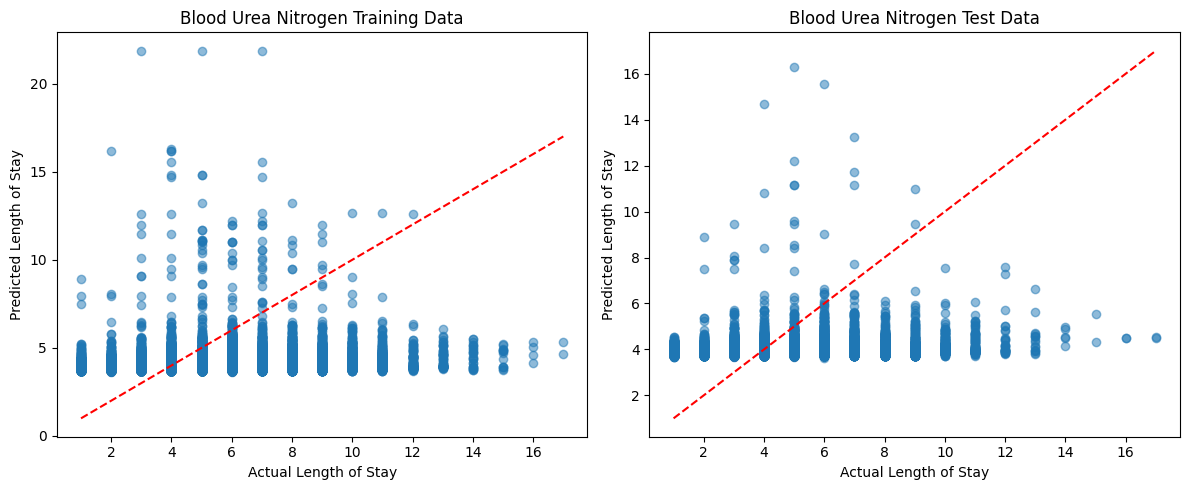

In [38]:
# PLOT
plt.figure(figsize=(12, 5))

# TRAINING DATA
plt.subplot(1, 2, 1)
plt.scatter(trainY, bloodureanitroTrainPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Blood Urea Nitrogen Training Data")
plt.plot([trainY.min(), trainY.max()], [trainY.min(), trainY.max()], 'r--')

# TEST DATA
plt.subplot(1, 2, 2)
plt.scatter(testY, bloodureanitroTestPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Blood Urea Nitrogen Test Data")
plt.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'r--')

plt.tight_layout()
plt.show()

### Metrics

In [39]:
# CHECK METRICS OF MODEL
print("R² score:", r2_score(testY, bloodureanitroTestPred))
print("MSE:", mean_squared_error(testY, bloodureanitroTestPred))
print("MAE:", mean_absolute_error(testY, bloodureanitroTestPred))

R² score: 0.021853147292590358
MSE: 5.476737736702539
MAE: 1.9047832086638679


## Creatinine

In [40]:
# CREATE MODEL OBJECT
creatinineModel = LinearRegression()

# TRAIN MODEL
creatinineModel.fit(creatinine_trainX, trainY)

# MAKE PREDICTIONS
creatinineTrainPred = creatinineModel.predict(creatinine_trainX)
creatinineTestPred = creatinineModel.predict(creatinine_testX)

### Performance Plot

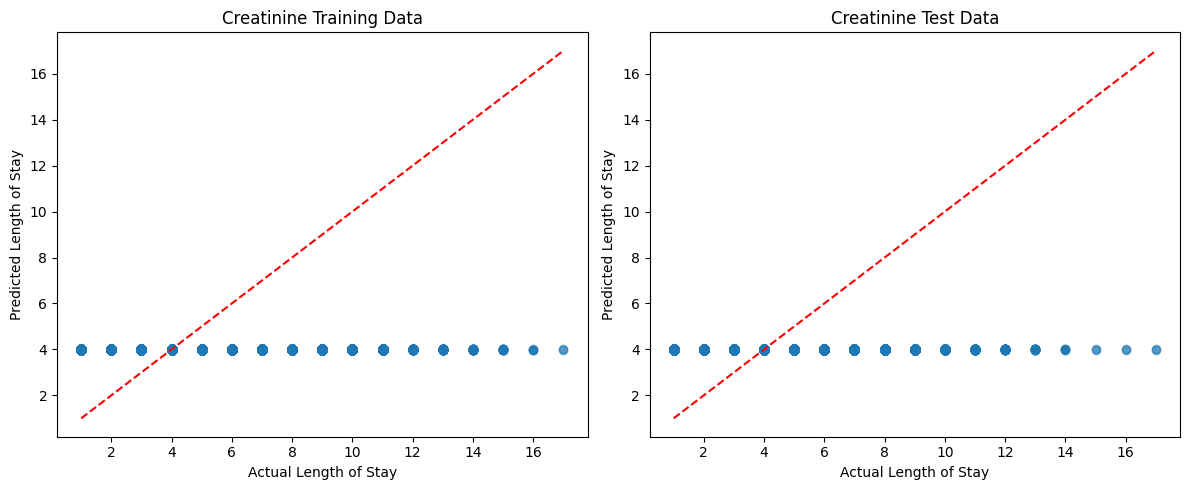

In [41]:
# PLOT
plt.figure(figsize=(12, 5))

# TRAINING DATA
plt.subplot(1, 2, 1)
plt.scatter(trainY, creatinineTrainPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Creatinine Training Data")
plt.plot([trainY.min(), trainY.max()], [trainY.min(), trainY.max()], 'r--')

# TEST DATA
plt.subplot(1, 2, 2)
plt.scatter(testY, creatinineTestPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Creatinine Test Data")
plt.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'r--')

plt.tight_layout()
plt.show()

### Metrics

In [42]:
# CHECK METRICS OF MODEL
print("R² score:", r2_score(testY, creatinineTestPred))
print("MSE:", mean_squared_error(testY, creatinineTestPred))
print("MAE:", mean_absolute_error(testY, creatinineTestPred))

R² score: -2.526621429366216e-05
MSE: 5.599237065449217
MAE: 1.9147509113852728


## BMI

In [43]:
# CREATE MODEL OBJECT
bmiModel = LinearRegression()

# TRAIN MODEL
bmiModel.fit(bmi_trainX, trainY)

# MAKE PREDICTIONS
bmiTrainPred = bmiModel.predict(bmi_trainX)
bmiTestPred = bmiModel.predict(bmi_testX)

### Performance Plot

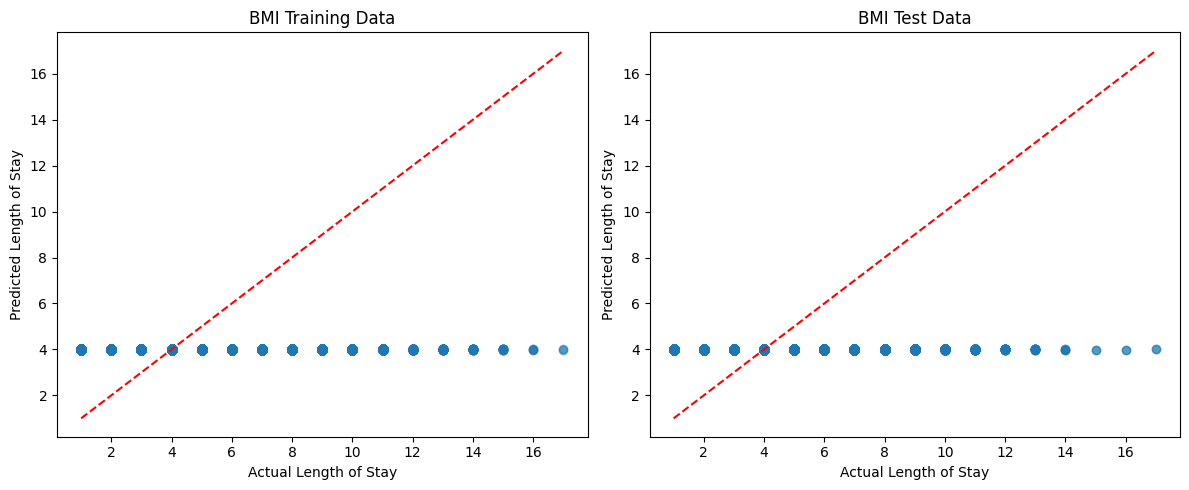

In [44]:
# PLOT
plt.figure(figsize=(12, 5))

# TRAINING DATA
plt.subplot(1, 2, 1)
plt.scatter(trainY, bmiTrainPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("BMI Training Data")
plt.plot([trainY.min(), trainY.max()], [trainY.min(), trainY.max()], 'r--')

# TEST DATA
plt.subplot(1, 2, 2)
plt.scatter(testY, bmiTestPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("BMI Test Data")
plt.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'r--')

plt.tight_layout()
plt.show()

### Metrics

In [45]:
# CHECK METRICS OF MODEL
print("R² score:", r2_score(testY, bmiTestPred))
print("MSE:", mean_squared_error(testY, bmiTestPred))
print("MAE:", mean_absolute_error(testY, bmiTestPred))

R² score: -6.445662179199729e-05
MSE: 5.599456496287306
MAE: 1.9142388688552208


## Pulse

In [46]:
# CREATE MODEL OBJECT
pulseModel = LinearRegression()

# TRAIN MODEL
pulseModel.fit(pulse_trainX, trainY)

# MAKE PREDICTIONS
pulseTrainPred = pulseModel.predict(pulse_trainX)
pulseTestPred = pulseModel.predict(pulse_testX)

### Performance Plot

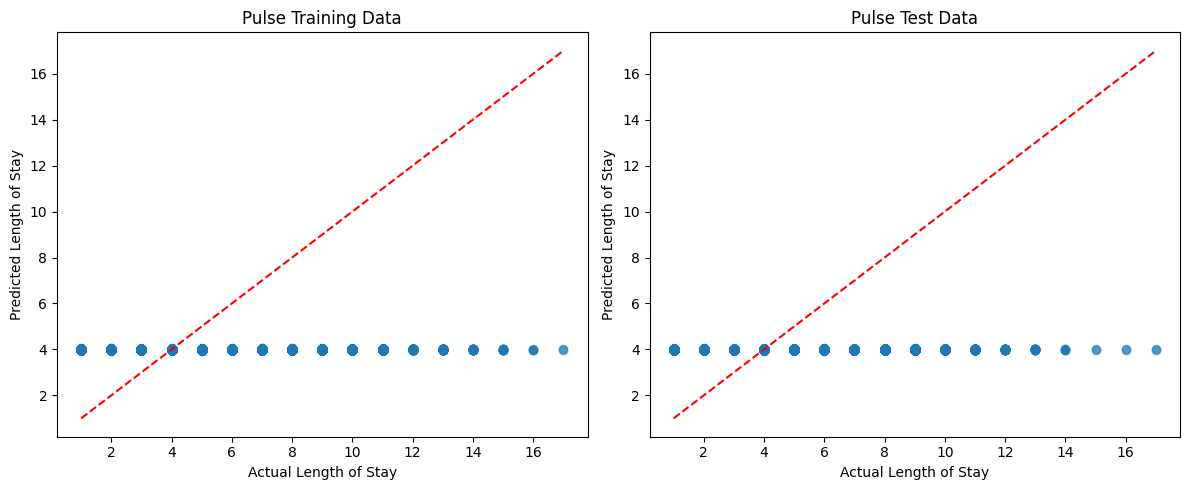

In [47]:
# PLOT
plt.figure(figsize=(12, 5))

# TRAINING DATA
plt.subplot(1, 2, 1)
plt.scatter(trainY, pulseTrainPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Pulse Training Data")
plt.plot([trainY.min(), trainY.max()], [trainY.min(), trainY.max()], 'r--')

# TEST DATA
plt.subplot(1, 2, 2)
plt.scatter(testY, pulseTestPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Pulse Test Data")
plt.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'r--')

plt.tight_layout()
plt.show()

### Metrics

In [48]:
# CHECK METRICS OF MODEL
print("R² score:", r2_score(testY, pulseTestPred))
print("MSE:", mean_squared_error(testY, pulseTestPred))
print("MAE:", mean_absolute_error(testY, pulseTestPred))

R² score: 5.014495550648146e-05
MSE: 5.598814831100388
MAE: 1.9151773189417094


## Respiration

In [49]:
# CREATE MODEL OBJECT
respirationModel = LinearRegression()

# TRAIN MODEL
respirationModel.fit(respiration_trainX, trainY)

# MAKE PREDICTIONS
respirationTrainPred = respirationModel.predict(respiration_trainX)
respirationTestPred = respirationModel.predict(respiration_testX)

### Performance Plot

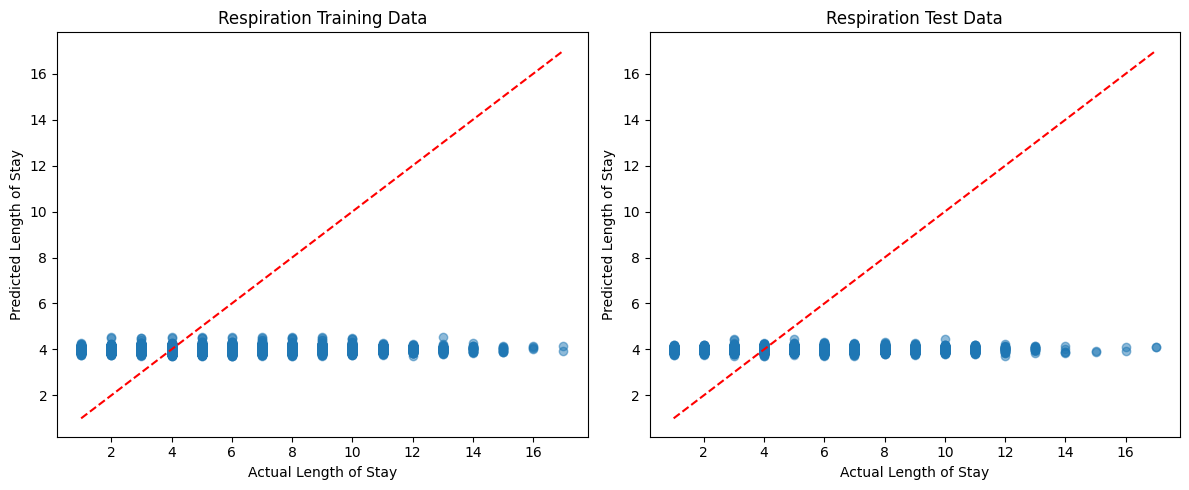

In [50]:
# PLOT
plt.figure(figsize=(12, 5))

# TRAINING DATA
plt.subplot(1, 2, 1)
plt.scatter(trainY, respirationTrainPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Respiration Training Data")
plt.plot([trainY.min(), trainY.max()], [trainY.min(), trainY.max()], 'r--')

# TEST DATA
plt.subplot(1, 2, 2)
plt.scatter(testY, respirationTestPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Respiration Test Data")
plt.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'r--')

plt.tight_layout()
plt.show()

### Metrics

In [51]:
# CHECK METRICS OF MODEL
print("R² score:", r2_score(testY, respirationTestPred))
print("MSE:", mean_squared_error(testY, respirationTestPred))
print("MAE:", mean_absolute_error(testY, respirationTestPred))

R² score: 0.0006567349327982752
MSE: 5.595418475829045
MAE: 1.9172509517031084


# FEATURE SELECTION
Examine the p-values for each feature.\
< 0.01 - Very strong evidence of relationship\
< 0.05 - Strong evidence of relationship\
0.05 - 0.1 - Weak evidence\
\> 0.1 - No evidence

In [52]:
# FEATURE SELECTION FOR NOISE
f_values, p_values = f_regression(X, y)
for i, val in enumerate(p_values):
  print("Feature: ", X.columns[i])
  print("\np-value: ", val)
  print("\n")

Feature:  rcount

p-value:  0.0


Feature:  dialysisrenalendstage

p-value:  0.0


Feature:  asthma

p-value:  9.323207982644667e-149


Feature:  irondef

p-value:  0.0


Feature:  pneum

p-value:  0.0


Feature:  substancedependence

p-value:  0.0


Feature:  psychologicaldisordermajor

p-value:  0.0


Feature:  depress

p-value:  0.0


Feature:  psychother

p-value:  0.0


Feature:  fibrosisandother

p-value:  4.202072209245217e-86


Feature:  malnutrition

p-value:  0.0


Feature:  hemo

p-value:  0.0


Feature:  hematocrit

p-value:  2.66979249531325e-91


Feature:  neutrophils

p-value:  0.0007507123678192392


Feature:  sodium

p-value:  0.26220411419611506


Feature:  glucose

p-value:  0.2756436334536005


Feature:  bloodureanitro

p-value:  0.0


Feature:  creatinine

p-value:  0.2029302260544204


Feature:  bmi

p-value:  0.9666879783333115


Feature:  pulse

p-value:  0.03455815515005984


Feature:  respiration

p-value:  1.7932173663757253e-12




## Features to keep
Very strong evidence of a linear relationship:
- rcount
- dialysisrenalendstage
- asthma
- irondef
- pneum
- substancedependence
- psychologicaldisordermajor
- depress
- psychother
- fibrosisandother
- malnutrition
- hemo
- hematocrit
- neutrophils
- bloodureanitro
- respiration

Strong evidence of a linear relationship:
- pulse

## Creating array with selected features

In [53]:
# DEFINE SELECTED FEATURES
selectedFeatures = ['rcount', 'dialysisrenalendstage', 'asthma', 'irondef', 'pneum', 'substancedependence', 'psychologicaldisordermajor', 'depress', 'psychother',
                    'fibrosisandother', 'malnutrition', 'hemo', 'hematocrit', 'neutrophils', 'bloodureanitro', 'respiration', 'pulse']

# CREATE NEW NUMPY ARRAYS USING ONLY THE SELECTED FEATURES
FS_normTrainX = normTrainX_df[selectedFeatures].to_numpy()
FS_normTestX = normTestX_df[selectedFeatures].to_numpy()
FS_stdTrainX = stdTrainX_df[selectedFeatures].to_numpy()
FS_stdTestX = stdTestX_df[selectedFeatures].to_numpy()

## Create Model Using Selected Features

In [54]:
# CREATE MODEL OBJECT
FS_normModel = LinearRegression()
FS_stdModel = LinearRegression()

# TRAIN MODEL
FS_normModel.fit(FS_normTrainX, trainY)
FS_stdModel.fit(FS_stdTrainX, trainY)

# MAKE PREDICTIONS
FS_normTrainPred = FS_normModel.predict(FS_normTrainX)
FS_normTestPred = FS_normModel.predict(FS_normTestX)
FS_stdTrainPred = FS_stdModel.predict(FS_stdTrainX)
FS_stdTestPred = FS_stdModel.predict(FS_stdTestX)

### Normalized Model

#### Performance Plot

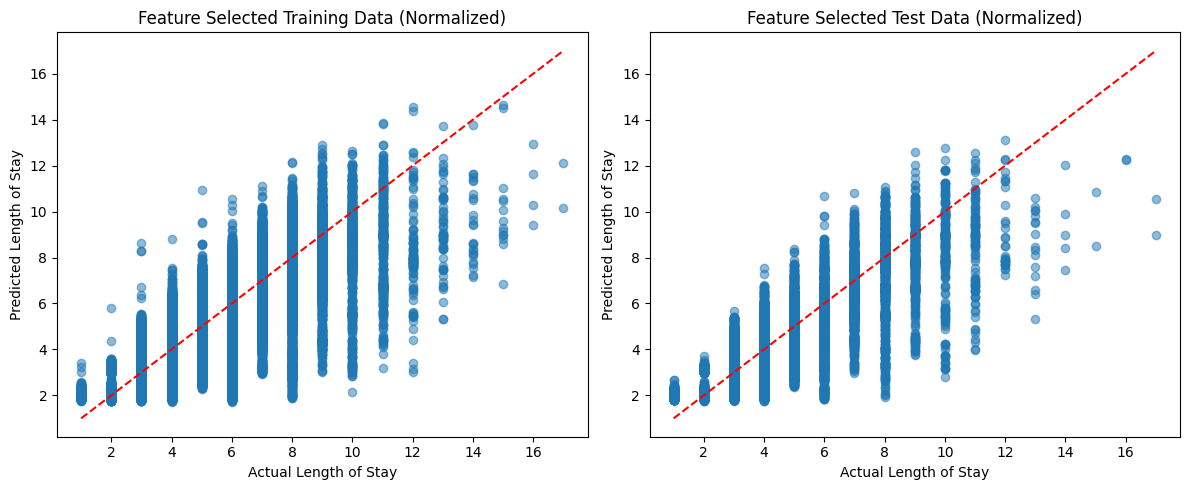

In [55]:
# PLOT
plt.figure(figsize=(12, 5))

# TRAINING DATA
plt.subplot(1, 2, 1)
plt.scatter(trainY, FS_normTrainPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Feature Selected Training Data (Normalized)")
plt.plot([trainY.min(), trainY.max()], [trainY.min(), trainY.max()], 'r--')

# TEST DATA
plt.subplot(1, 2, 2)
plt.scatter(testY, FS_normTestPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Feature Selected Test Data (Normalized)")
plt.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'r--')

plt.tight_layout()
plt.show()

#### Metrics

In [56]:
# CHECK METRICS OF MODEL
print("R² score:", r2_score(testY, FS_normTestPred))
print("MSE:", mean_squared_error(testY, FS_normTestPred))
print("MAE:", mean_absolute_error(testY, FS_normTestPred))

R² score: 0.7497589188284427
MSE: 1.4011237359013067
MAE: 0.8999274909856567


### Standardized Model

#### Performance Plot

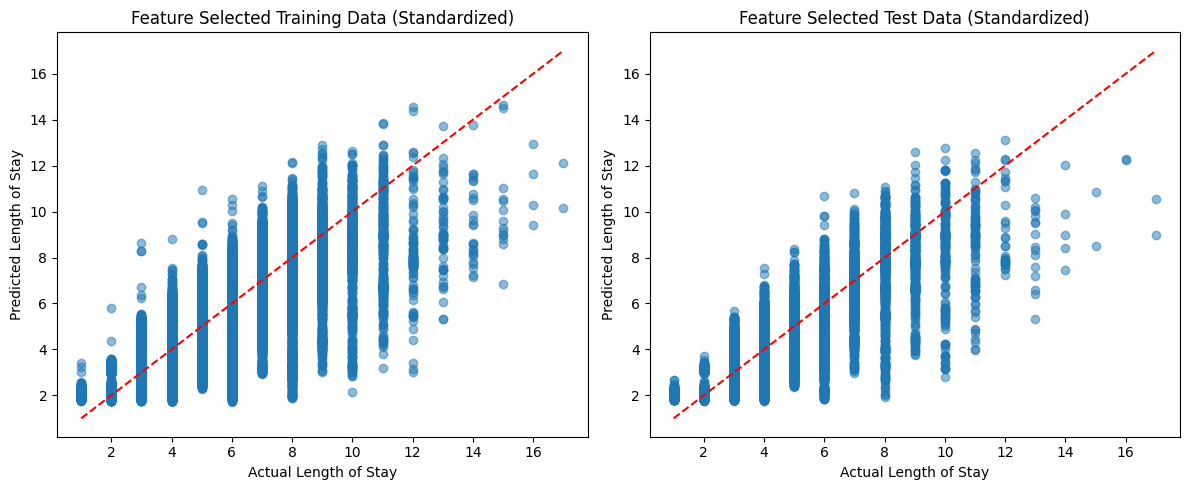

In [57]:
# PLOT
plt.figure(figsize=(12, 5))

# TRAINING DATA
plt.subplot(1, 2, 1)
plt.scatter(trainY, FS_stdTrainPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Feature Selected Training Data (Standardized)")
plt.plot([trainY.min(), trainY.max()], [trainY.min(), trainY.max()], 'r--')

# TEST DATA
plt.subplot(1, 2, 2)
plt.scatter(testY, FS_stdTestPred, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Feature Selected Test Data (Standardized)")
plt.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'r--')

plt.tight_layout()
plt.show()

#### Metrics

In [58]:
# CHECK METRICS OF MODEL
print("R² score:", r2_score(testY, FS_stdTestPred))
print("MSE:", mean_squared_error(testY, FS_stdTestPred))
print("MAE:", mean_absolute_error(testY, FS_stdTestPred))

R² score: 0.7497589188284428
MSE: 1.4011237359013065
MAE: 0.8999274909856565


## Feature Weights

### Normalized

In [59]:
# Get feature names (excluding target)
feature_names = normTrainX_df.columns

# Get weights (coefficients)
norm_weights = FS_normModel.coef_.flatten()

# Pair them with feature names
norm_feature_weights = list(zip(feature_names, norm_weights))

# Sort by absolute weight (optional, to see biggest influences)
norm_feature_weights = sorted(norm_feature_weights, key=lambda x: abs(x[1]), reverse=True)

# Display
for feature, weight in norm_feature_weights:
    print(f"{feature}: {weight:.4f}")

sodium: 5.6109
neutrophils: 4.4914
hemo: 1.2615
psychologicaldisordermajor: 1.2380
fibrosisandother: 1.1789
rcount: 1.1494
substancedependence: 0.9176
asthma: 0.8396
irondef: 0.7702
psychother: 0.7699
dialysisrenalendstage: 0.7482
pneum: 0.6807
malnutrition: 0.5061
depress: 0.4920
hematocrit: 0.3488
glucose: -0.1783
bloodureanitro: -0.0111


### Standardized

In [60]:
std_weights = FS_stdModel.coef_.flatten()
std_feature_weights = list(zip(feature_names, std_weights))
std_feature_weights = sorted(std_feature_weights, key=lambda x: abs(x[1]), reverse=True)

for feature, weight in std_feature_weights:
    print(f"{feature}: {weight:.4f}")

hemo: 1.2615
psychologicaldisordermajor: 1.2380
fibrosisandother: 1.1789
rcount: 1.1494
substancedependence: 0.9176
asthma: 0.8396
irondef: 0.7702
psychother: 0.7699
dialysisrenalendstage: 0.7482
pneum: 0.6807
malnutrition: 0.5061
depress: 0.4920
sodium: 0.1078
neutrophils: 0.0989
hematocrit: 0.0360
glucose: -0.0104
bloodureanitro: -0.0012


# FEATURE INTERACTIONS

## Check which features may interact

In [61]:
# FEATURES TO CHECK
features = ['dialysisrenalendstage', 'asthma', 'irondef', 'pneum', 'substancedependence',
            'psychologicaldisordermajor', 'depress', 'psychother', 'fibrosisandother',
            'malnutrition', 'hemo', 'rcount', 'hematocrit', 'neutrophils', 'sodium', 'glucose',
            'bloodureanitro', 'creatinine', 'bmi', 'pulse', 'respiration']

interaction_results = []

# LOOP THROUGH ALL UNIQUE PAIRS
for feature1, feature2 in combinations(features, 2):
    # Create interaction term for training
    interaction_train = trainX[feature1] * trainX[feature2]
    interaction_train = interaction_train.to_numpy().reshape(-1, 1)

    # Train model
    model = LinearRegression()
    model.fit(interaction_train, trainY)

    # Create interaction term for testing
    interaction_test = testX[feature1] * testX[feature2]
    interaction_test = interaction_test.to_numpy().reshape(-1, 1)

    # Predict and evaluate
    preds = model.predict(interaction_test)
    r2 = r2_score(testY, preds)

    # Store results
    interaction_results.append((f"{feature1} * {feature2}", r2))

# Sort and display
interaction_results.sort(key=lambda x: x[1], reverse=True)
results_df = pd.DataFrame(interaction_results, columns=["Interaction Term", "R² Score"])
print(results_df)

         Interaction Term  R² Score
0         rcount * sodium  0.561581
1            rcount * bmi  0.558260
2    rcount * respiration  0.553744
3          rcount * pulse  0.544087
4     rcount * creatinine  0.534965
..                    ...       ...
205    creatinine * pulse -0.000057
206       glucose * pulse -0.000060
207          sodium * bmi -0.000061
208      sodium * glucose -0.000064
209   pulse * respiration -0.000084

[210 rows x 2 columns]


## Create interaction term columns
Will use the top 5 interacting terms
1. rcount * sodium
2. rcount * bmi
3. rcount * pulse
4. rcount * respiration
5. rcount * creatinine

In [62]:
# CREATE INTERACTING TERM COLUMNS
top_interactions = [
    ('rcount', 'sodium'),
    ('rcount', 'bmi'),
    ('rcount', 'pulse'),
    ('rcount', 'respiration'),
    ('rcount', 'creatinine')
]

# NORMALIZED DATA
for feat1, feat2 in top_interactions:
    interaction_name = f"{feat1} * {feat2}"
    normTrainX_df[interaction_name] = normTrainX_df[feat1] * normTrainX_df[feat2]
    normTestX_df[interaction_name] = normTestX_df[feat1] * normTestX_df[feat2]

# STANDARDIZED DATA
for feat1, feat2 in top_interactions:
    interaction_name = f"{feat1} * {feat2}"
    stdTrainX_df[interaction_name] = stdTrainX_df[feat1] * stdTrainX_df[feat2]
    stdTestX_df[interaction_name] = stdTestX_df[feat1] * stdTestX_df[feat2]

# VERIFY THEY WERE ADDED
#print("Normalized columns now:", normTrainX_df.columns[-5:])
#print("Standardized columns now:", stdTrainX_df.columns[-5:])

In [63]:
# CREATE NUMPY ARRAYS
normTrainX_interacting = normTrainX_df.to_numpy()
normTestX_interacting = normTestX_df.to_numpy()
stdTrainX_interacting = stdTrainX_df.to_numpy()
stdTestX_interacting = stdTestX_df.to_numpy()

## Train Model

In [64]:
# TRAIN NORMALIZED MODEL
normModel_interacting = LinearRegression()
normModel_interacting.fit(normTrainX_interacting, trainY)

# TRAIN STANDARDIZED MODEL
stdModel_interacting = LinearRegression()
stdModel_interacting.fit(stdTrainX_interacting, trainY)

# MAKE PREDICTIONS
normTrainPred_interacting = normModel_interacting.predict(normTrainX_interacting)
normTestPred_interacting = normModel_interacting.predict(normTestX_interacting)
stdTrainPred_interacting = stdModel_interacting.predict(stdTrainX_interacting)
stdTestPred_interacting = stdModel_interacting.predict(stdTestX_interacting)

### Normalized Model

#### Performance Plot

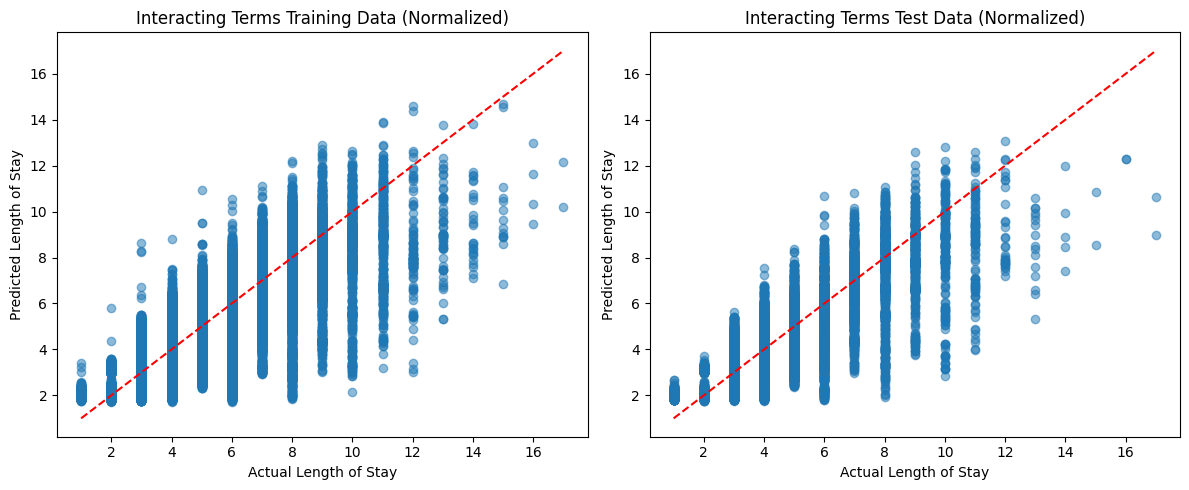

In [65]:
# PLOT
plt.figure(figsize=(12, 5))

# TRAINING DATA
plt.subplot(1, 2, 1)
plt.scatter(trainY, normTrainPred_interacting, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Interacting Terms Training Data (Normalized)")
plt.plot([trainY.min(), trainY.max()], [trainY.min(), trainY.max()], 'r--')

# TEST DATA
plt.subplot(1, 2, 2)
plt.scatter(testY, normTestPred_interacting, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Interacting Terms Test Data (Normalized)")
plt.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'r--')

plt.tight_layout()
plt.show()

#### Metrics

In [66]:
# CHECK METRICS OF MODEL
print("R² score:", r2_score(testY, normTestPred_interacting))
print("MSE:", mean_squared_error(testY, normTestPred_interacting))
print("MAE:", mean_absolute_error(testY, normTestPred_interacting))

R² score: 0.7497121827416956
MSE: 1.4013854157188568
MAE: 0.9000629514510281


### Standardized Model

#### Performance Plot

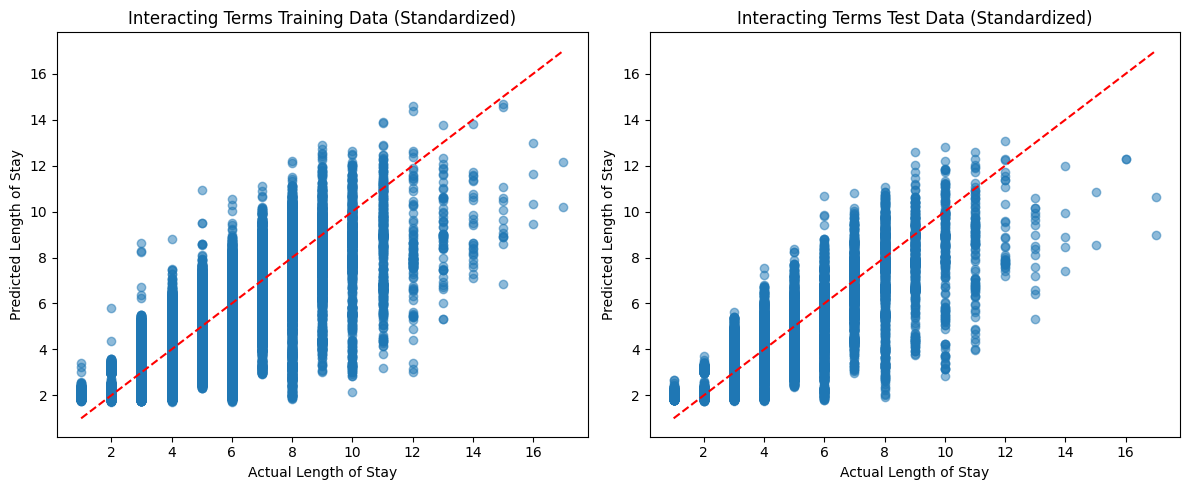

In [67]:
# PLOT
plt.figure(figsize=(12, 5))

# TRAINING DATA
plt.subplot(1, 2, 1)
plt.scatter(trainY, stdTrainPred_interacting, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Interacting Terms Training Data (Standardized)")
plt.plot([trainY.min(), trainY.max()], [trainY.min(), trainY.max()], 'r--')

# TEST DATA
plt.subplot(1, 2, 2)
plt.scatter(testY, stdTestPred_interacting, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Interacting Terms Test Data (Standardized)")
plt.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'r--')

plt.tight_layout()
plt.show()

#### Metrics

In [68]:
# CHECK METRICS OF MODEL
print("R² score:", r2_score(testY, stdTestPred_interacting))
print("MSE:", mean_squared_error(testY, stdTestPred_interacting))
print("MAE:", mean_absolute_error(testY, stdTestPred_interacting))

R² score: 0.7497121827416957
MSE: 1.4013854157188566
MAE: 0.9000629514510278


## Feature Weights

### Normalized

In [69]:
# Get feature names (excluding target)
feature_names = normTrainX_df.columns

# Get weights (coefficients)
norm_weights = normModel_interacting.coef_.flatten()

# Pair them with feature names
norm_feature_weights = list(zip(feature_names, norm_weights))

# Sort by absolute weight (optional, to see biggest influences)
norm_feature_weights = sorted(norm_feature_weights, key=lambda x: abs(x[1]), reverse=True)

# Display
for feature, weight in norm_feature_weights:
    print(f"{feature}: {weight:.4f}")

bloodureanitro: 5.6113
neutrophils: 4.4864
hemo: 1.2616
psychologicaldisordermajor: 1.2379
rcount: 1.2234
fibrosisandother: 1.1798
substancedependence: 0.9175
asthma: 0.8393
irondef: 0.7705
psychother: 0.7698
dialysisrenalendstage: 0.7481
pneum: 0.6810
malnutrition: 0.5063
depress: 0.4920
hematocrit: 0.3480
respiration: -0.1167
rcount * sodium: -0.0573
rcount * respiration: -0.0528
bmi: 0.0465
sodium: 0.0447
rcount * pulse: -0.0348
pulse: 0.0272
rcount * creatinine: 0.0218
rcount * bmi: -0.0143
creatinine: -0.0140
glucose: 0.0063


### Standardized

In [70]:
std_weights = stdModel_interacting.coef_.flatten()
std_feature_weights = list(zip(feature_names, std_weights))
std_feature_weights = sorted(std_feature_weights, key=lambda x: abs(x[1]), reverse=True)

for feature, weight in std_feature_weights:
    print(f"{feature}: {weight:.4f}")

hemo: 1.2616
psychologicaldisordermajor: 1.2379
fibrosisandother: 1.1798
rcount: 1.1494
substancedependence: 0.9175
asthma: 0.8393
irondef: 0.7705
psychother: 0.7698
dialysisrenalendstage: 0.7481
pneum: 0.6810
malnutrition: 0.5063
depress: 0.4920
bloodureanitro: 0.1078
neutrophils: 0.0988
hematocrit: 0.0359
respiration: -0.0068
rcount * sodium: -0.0066
bmi: 0.0055
sodium: 0.0051
rcount * pulse: -0.0038
rcount * respiration: -0.0031
pulse: 0.0030
rcount * creatinine: 0.0024
rcount * bmi: -0.0017
creatinine: -0.0015
glucose: 0.0007


# RANDOM FOREST REGRESSOR
Ensemble Decision Tree Algorithm that makes predictions by averaging output of all those trees. Works well for non-linear relationships

## Train Model

In [71]:
from sklearn.ensemble import RandomForestRegressor

# CREATE MODEL OBJECT
normModel_rf = RandomForestRegressor()
stdModel_rf = RandomForestRegressor()

# TRAIN MODEL
normModel_rf.fit(normTrainX_interacting, trainY)
stdModel_rf.fit(stdTrainX_interacting, trainY)

# MAKE PREDICTIONS
normTrainPred_rf = normModel_rf.predict(normTrainX_interacting)
normTestPred_rf = normModel_rf.predict(normTestX_interacting)
stdTrainPred_rf = stdModel_rf.predict(stdTrainX_interacting)
stdTestPred_rf = stdModel_rf.predict(stdTestX_interacting)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


## Normalized Model

### Performance Plot

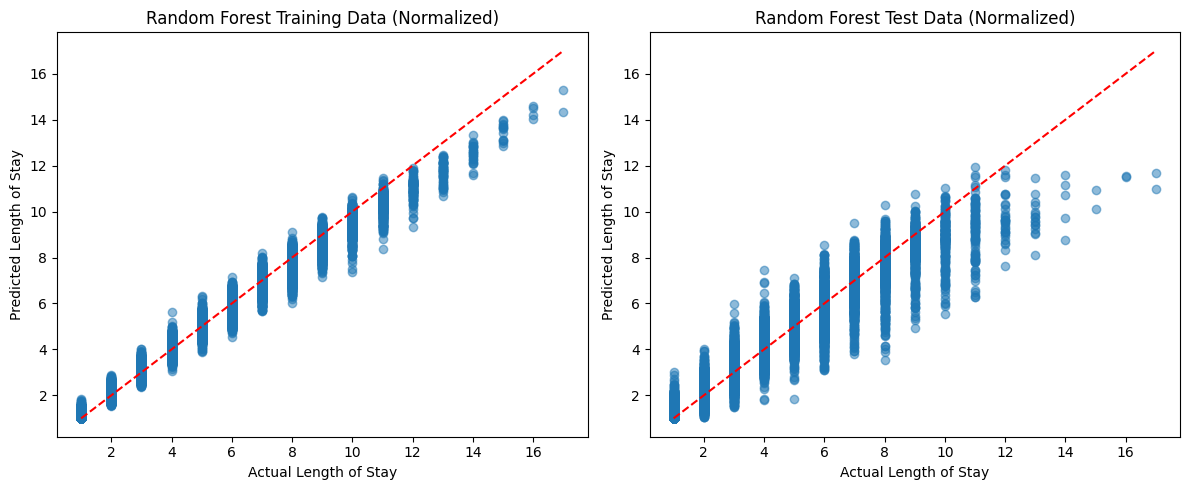

In [72]:
# PLOT
plt.figure(figsize=(12, 5))

# TRAINING DATA
plt.subplot(1, 2, 1)
plt.scatter(trainY, normTrainPred_rf, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Random Forest Training Data (Normalized)")
plt.plot([trainY.min(), trainY.max()], [trainY.min(), trainY.max()], 'r--')

# TEST DATA
plt.subplot(1, 2, 2)
plt.scatter(testY, normTestPred_rf, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Random Forest Test Data (Normalized)")
plt.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'r--')

plt.tight_layout()
plt.show()

### Metrics

In [73]:
# CHECK METRICS OF MODEL
print("R² score:", r2_score(testY, normTestPred_rf))
print("MSE:", mean_squared_error(testY, normTestPred_rf))
print("MAE:", mean_absolute_error(testY, normTestPred_rf))

R² score: 0.9278130533830379
MSE: 0.40418161499999994
MAE: 0.3807865


## Standardized Model

### Performance Plot

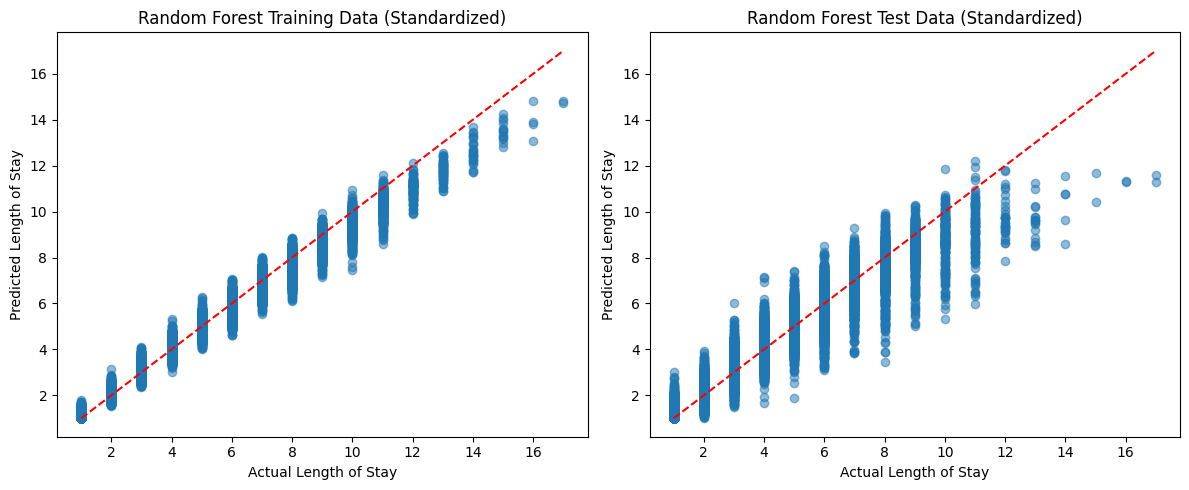

In [74]:
# PLOT
plt.figure(figsize=(12, 5))

# TRAINING DATA
plt.subplot(1, 2, 1)
plt.scatter(trainY, stdTrainPred_rf, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Random Forest Training Data (Standardized)")
plt.plot([trainY.min(), trainY.max()], [trainY.min(), trainY.max()], 'r--')

# TEST DATA
plt.subplot(1, 2, 2)
plt.scatter(testY, stdTestPred_rf, alpha=0.5)
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Random Forest Test Data (Standardized)")
plt.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'r--')

plt.tight_layout()
plt.show()

### Metrics

In [75]:
# CHECK METRICS OF MODEL
print("R² score:", r2_score(testY, stdTestPred_rf))
print("MSE:", mean_squared_error(testY, stdTestPred_rf))
print("MAE:", mean_absolute_error(testY, stdTestPred_rf))

R² score: 0.9270011919099047
MSE: 0.40872730500000004
MAE: 0.38312949999999996
